In this notebook we will try to visualize the 2m temperature variable, and the surface input variables. 

In [34]:
import os, numpy as np, xarray as xr, matplotlib.pyplot as plt
import matplotlib.tri as tri, cartopy.crs as ccrs, cartopy.feature as cfeature


In [43]:
# Retrieve files

TARGET_DATE = "20250301" # example initial date (YYYYMMDD)
FORECAST_FILE = f"/home/nishidh/library/data/forecasts/2025/fcst_t2m_30mem_192h_{TARGET_DATE}.nc"
SURFACE_FILE  = f"/home/nishidh/library/data/surface_inputs/2025/sfc_input_{TARGET_DATE}.nc"
GRID_FILE     = f"/home/nishidh/library/data/grid/master_grid_n320.nc"

In [ ]:
ds_grid = xr.open_dataset(GRID_FILE) # load the grid -- this contains lat/lon values in order for N320 grid
lons, lats = ds_grid.longitude.values, ds_grid.latitude.values

print(ds_grid) # inspect

<xarray.Dataset> Size: 9MB
Dimensions:    (node: 542080)
Coordinates:
    latitude   (node) float64 4MB 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude  (node) float64 4MB 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
Dimensions without coordinates: node
Data variables:
    *empty*


In [47]:
# Pre-compute Triangulation (this is because the grid is unstructured)
# Normalize lons to -180..180 for correct map wrapping
lons = np.where(lons > 180, lons - 360, lons)
triang = tri.Triangulation(lons, lats)

In [49]:
ds = xr.open_dataset(FORECAST_FILE) # load forecast data
print(ds) # inspect

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 32, member: 30, node: 542080)
Coordinates:
  * time     (time) datetime64[ns] 256B 2025-03-01T06:00:00 ... 2025-03-09
  * member   (member) int64 240B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29
Dimensions without coordinates: node
Data variables:
    t2m      (time, member, node) float32 2GB ...


In [57]:
# to print lat/long value corresponding to a particualar grid point (total -- 542080)
print(ds_grid.latitude.values[0], ds_grid.longitude.values[0])
print(ds_grid.latitude.values[12000], ds_grid.longitude.values[12000])

89.78487690721863 0.0
73.20837306000952 60.9375


In [82]:
# 2m temperature values in the forecast date are arranged in the same order as the ds_grid file

print("time stamps:", ds.time.values) # time values +6 hrs to +192 hrs from initial date (0 hrs)
print("member:", ds.member.values) # ensemble member values (0-29 for 30 members)
print("index:", ds.node.values) # the index (0-542079 for N320 grid)


time stamps: ['2025-03-01T06:00:00.000000000' '2025-03-01T12:00:00.000000000'
 '2025-03-01T18:00:00.000000000' '2025-03-02T00:00:00.000000000'
 '2025-03-02T06:00:00.000000000' '2025-03-02T12:00:00.000000000'
 '2025-03-02T18:00:00.000000000' '2025-03-03T00:00:00.000000000'
 '2025-03-03T06:00:00.000000000' '2025-03-03T12:00:00.000000000'
 '2025-03-03T18:00:00.000000000' '2025-03-04T00:00:00.000000000'
 '2025-03-04T06:00:00.000000000' '2025-03-04T12:00:00.000000000'
 '2025-03-04T18:00:00.000000000' '2025-03-05T00:00:00.000000000'
 '2025-03-05T06:00:00.000000000' '2025-03-05T12:00:00.000000000'
 '2025-03-05T18:00:00.000000000' '2025-03-06T00:00:00.000000000'
 '2025-03-06T06:00:00.000000000' '2025-03-06T12:00:00.000000000'
 '2025-03-06T18:00:00.000000000' '2025-03-07T00:00:00.000000000'
 '2025-03-07T06:00:00.000000000' '2025-03-07T12:00:00.000000000'
 '2025-03-07T18:00:00.000000000' '2025-03-08T00:00:00.000000000'
 '2025-03-08T06:00:00.000000000' '2025-03-08T12:00:00.000000000'
 '2025-03-08

The first time step (index = 0) is +6 hrs from initial date, and the last time step is +192 hrs from initial date. There are 30 ensemble members (0-29). The grid points are arranged in the same order as in the grid file (0-542079 for N320 grid). For example, the 25th time step (index 25) corresponds forecast of t2m at 6 x (25+1) = +156 hrs from initial date

In [99]:
print(ds.t2m.isel(time=0, member=0, node=0).item())
print(ds.t2m.isel(time=0, member=1, node=0).item())
print(ds.t2m.isel(time=0, member=21, node=0).item())
print(ds.t2m.isel(time=0, member=0, node=12000).item())
print(ds.t2m.isel(time=25, member=13, node=12000).item()) 
print(ds.t2m.isel(time=31, member=29, node=225353).item()) # last time step of the last member at grid point index 225353

265.515625
265.3515625
264.6640625
250.5859375
256.9375
298.890625


## Visualizing the t2m field


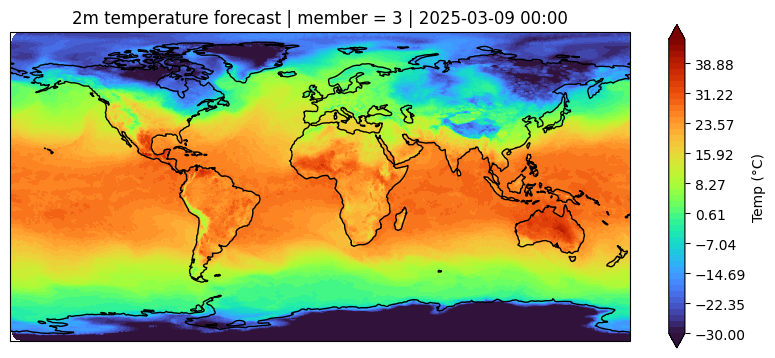

In [108]:
member = 3  

data = ds.t2m.isel(time=31, member=member).values - 273.15
timestamp = ds.time.isel(time=31).dt.strftime("%Y-%m-%d %H:%M").item()

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

img = ax.tricontourf(
    triang,
    data,
    levels=np.linspace(-30, 45, 50),
    cmap='turbo',
    extend='both'
)

plt.colorbar(img, ax=ax, shrink=0.7, label="Temp (°C)")
plt.title(f"2m temperature forecast | member = {member} | {timestamp}")

plt.show()


## Surface variables (inputs)
These will be required for calculating climatology.

The following variables are available:
VARS = ['10u', '10v', '2d', '2t', 'msl', 'skt', 'sp', 'tcw', 'lsm', 'z', 'slor', 'sdor', 'stl1', 'stl2']

| variable abbreviation | description |
|---------:|----------------|
| 10u | 10-metre U-component of wind |
| 10v | 10-metre V-component of wind |
| 2d | 2-metre dewpoint temperature |
| 2t | 2-metre temperature |
| msl | Mean sea level pressure |
| skt | Skin temperature |
| sp | Surface pressure |
| tcw | Total column water |
| lsm | Land–sea mask |
| z | Geopotential |
| slor | Standard deviation of sub-gridscale orography (slope) |
| sdor | Standard deviation of sub-gridscale orography |
| stl1 | Soil temperature level 1 |
| stl2 | Soil temperature level 2 |


In [113]:
ds_surface = xr.open_dataset(SURFACE_FILE) # load surface input data
print(list(ds_surface.data_vars)) # inspect
print(ds_surface)

['10u', '10v', '2d', '2t', 'msl', 'skt', 'sp', 'tcw', 'lsm', 'z', 'slor', 'sdor', 'stl1', 'stl2']
<xarray.Dataset> Size: 121MB
Dimensions:  (time: 2, node: 542080)
Coordinates:
  * time     (time) datetime64[ns] 16B 2025-02-28T18:00:00 2025-03-01
Dimensions without coordinates: node
Data variables: (12/14)
    10u      (time, node) float64 9MB ...
    10v      (time, node) float64 9MB ...
    2d       (time, node) float64 9MB ...
    2t       (time, node) float64 9MB ...
    msl      (time, node) float64 9MB ...
    skt      (time, node) float64 9MB ...
    ...       ...
    lsm      (time, node) float64 9MB ...
    z        (time, node) float64 9MB ...
    slor     (time, node) float64 9MB ...
    sdor     (time, node) float64 9MB ...
    stl1     (time, node) float64 9MB ...
    stl2     (time, node) float64 9MB ...


The gridded representation is similar to the t2m variable. But there are only two time steps per day (0 and -6 hrs from any given date). And there are no ensemble members of course. 

In [ ]:
# two time steps per day: 0 and -6 hrs

# to print a particular variable value at a particular grid point

print(ds_surface["10v"].isel(time=0, node=34341).item())
print(ds_surface["10v"].isel(time=1, node=34341).item()) 

8.224517822265625
13.61138916015625


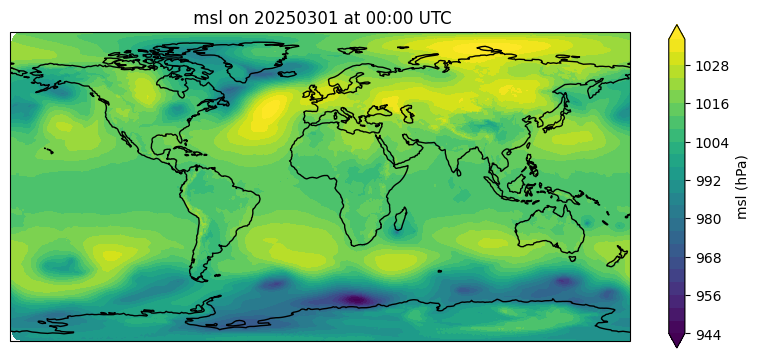

In [132]:
data = ds_surface.msl.isel(time=1).values / 100.0  # Pa to hPa conversion

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

img = ax.tricontourf(
    triang,
    data,
    levels=30,
    cmap='viridis',
    extend='both'
)

plt.colorbar(img, ax=ax, shrink=0.7, label="msl (hPa)")
plt.title(f" msl on {TARGET_DATE} at 00:00 UTC")

plt.show()

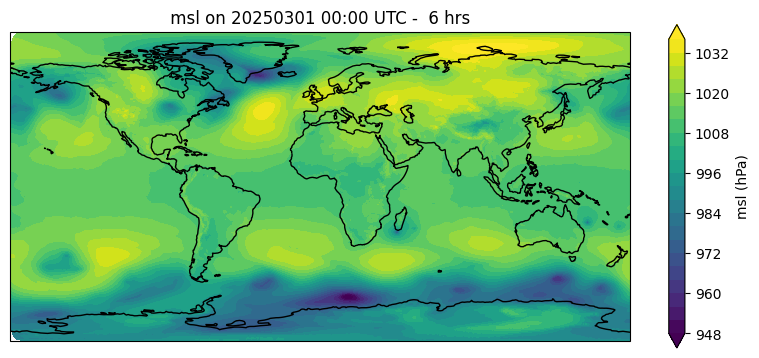

In [133]:
data_1 = ds_surface.msl.isel(time=0).values / 100.0  # Pa to hPa conversion

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

img = ax.tricontourf(
    triang,
    data_1,
    levels=30,
    cmap='viridis',
    extend='both'
)

plt.colorbar(img, ax=ax, shrink=0.7, label="msl (hPa)")
plt.title(f" msl on {TARGET_DATE} 00:00 UTC -  6 hrs ")

plt.show()